In [38]:
# | echo: false
# | output: false
# | warning: false

import tomlkit
import scanpy as sc
from anndata import AnnData
import pandas as pd
from sklearn.metrics import davies_bouldin_score

import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib import rc_context
import patchworklib as pw
from utils.preprocessing_funcs import (
    get_var_features_num,
    select_n_uniform,
)
from numbers import Number


import itables
from os import path
import session_info
import logging
from tempfile import TemporaryDirectory
from os import system

logging.basicConfig(level=logging.ERROR)

In [39]:
# | echo: true
# | output: false
# | warning: false

"in the following cell, override the default pipeline parameters if needed"
HVG_BY_BATCH = False
VARIABLE_FEATURES = 0.1  # a fraction between 0.0 and 1.0 or a number of genes.
CLUSTERING_RANGE = [
    0.0,
    3.0,
    0.1,
]  # Range of resolution for clustering, (min, max, step).


# TODO: Check the best implementation for variable regression
# REGRESS_VARIABLES = []  # List: Variables to regress out (default: []).

# Config

In [40]:
# | echo: false
# | output: false
# | warning: false

## Pipeline parameters
with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [41]:
# | echo: false
# | output: false
# | warning: false

ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])

NORMALIZATION_METHOD = config["normalization"]["NORMALIZATION_METHOD"]
COUNTS_LAYER = config["normalization"]["COUNTS_LAYER"]
CLUSTERING_COL = config["clustering"]["CLUSTERING_COL"]

In [42]:
# | echo: false
# | output: false
# | warning: false

adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

In [43]:
adata.obs.drop(
    columns=[col for col in adata.obs.columns if "leiden" in col],
    errors="ignore",
    inplace=True,
)

# Normalize object

In [44]:
# | echo: false
# | output: false
# | warning: false

from tomlkit.items import String, Array


# Getting a stable counts layer to be used later, setting X to be raw count values.
if COUNTS_LAYER == "X":
    adata.layers["counts"] = adata.X.copy()
    COUNTS_LAYER = "counts"
elif COUNTS_LAYER in adata.layers.keys():
    adata.X = adata.layers[COUNTS_LAYER].copy()
else:
    raise ValueError("{COUNTS_LAYER} layer can't be found in the object")


var_features = get_var_features_num(adata, VARIABLE_FEATURES)


# BUG: No stable counts slot, reach to the counts slot.
def normalize_adata(
    adata: AnnData, normalization_method: String, counts_layer: str
) -> None:

    if normalization_method not in ["log_norm", "p_residuals"]:
        raise ValueError(
            "Invalid normalization method, only 'log_norm' and 'p_residuals' are supported."
        )

    if normalization_method == "log_norm":
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
        adata.layers["log_norm"] = adata.X.copy()

        # https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html
        # Similair to Seurat FindVariableFeatures(method='vst')
        if HVG_BY_BATCH:
            sc.pp.highly_variable_genes(
                adata, n_top_genes=var_features, batch_key="sample", flavor="seurat_v3"
            )
        else:
            sc.pp.highly_variable_genes(
                adata, n_top_genes=var_features, batch_key=None, flavor="seurat_v3"
            )

    if normalization_method == "p_residuals":
        # Recipie for variable feature selection, pearson normalization, and PCA
        adata = sc.experimental.pp.recipe_pearson_residuals(
            adata=adata, n_top_genes=var_features
        )
        adata["p_residuals"] = adata.X.copy()


normalize_adata(adata, NORMALIZATION_METHOD, COUNTS_LAYER)

# Select Variable Features

number of variable genes is: 3660


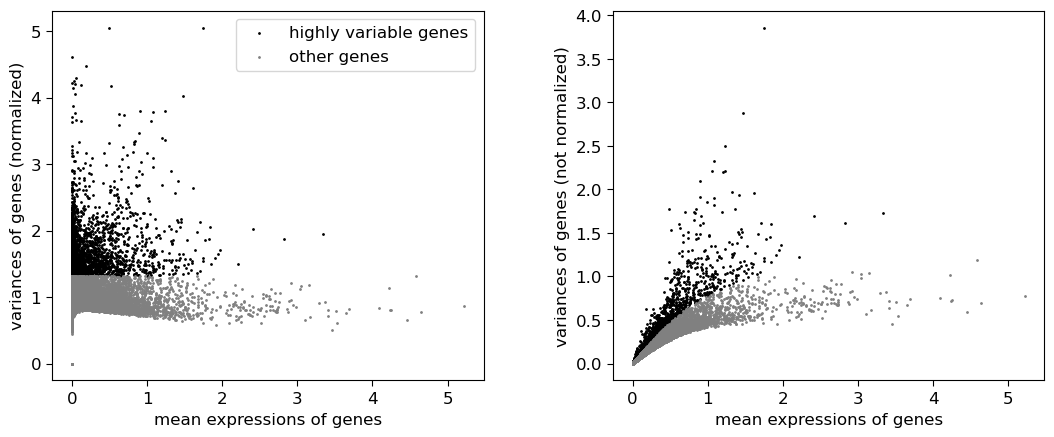

In [45]:
# | echo: false
# | warning: false

print(f"number of variable genes is: {var_features}")
sc.pl.highly_variable_genes(adata)

# Clustering 

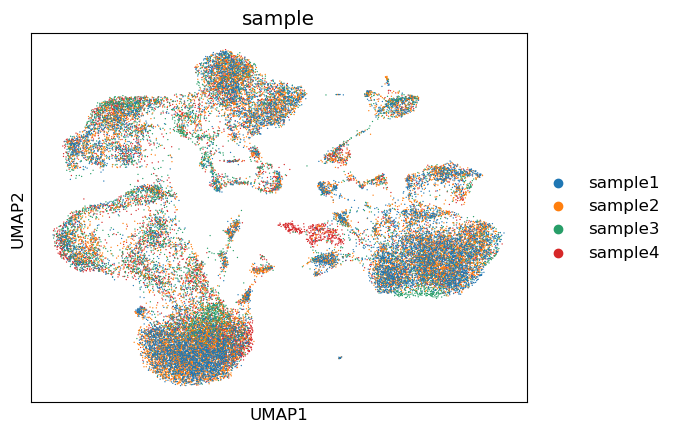

In [46]:
# | echo: false
# | warning: false

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="sample")

In [47]:
# | echo: false
# | output: false
# | warning: false


clustering_keys_added = []

assert len(CLUSTERING_RANGE) == 3
assert all([isinstance(i, Number) for i in CLUSTERING_RANGE])

# If the min_range is 0, skip the first round and start from 0 + step.
min_range = (
    CLUSTERING_RANGE[0]
    if CLUSTERING_RANGE[0] > 0
    else CLUSTERING_RANGE[0] + CLUSTERING_RANGE[2]
)
max_range = CLUSTERING_RANGE[1]
step = CLUSTERING_RANGE[2]

for i in np.arange(min_range, max_range, step):
    resolution = np.around(i, decimals=3)
    sc.tl.leiden(adata=adata, key_added=f"leiden_{resolution}", resolution=resolution)
    clustering_keys_added.append(f"leiden_{resolution}")

## Clustering Metrics

### Clustree

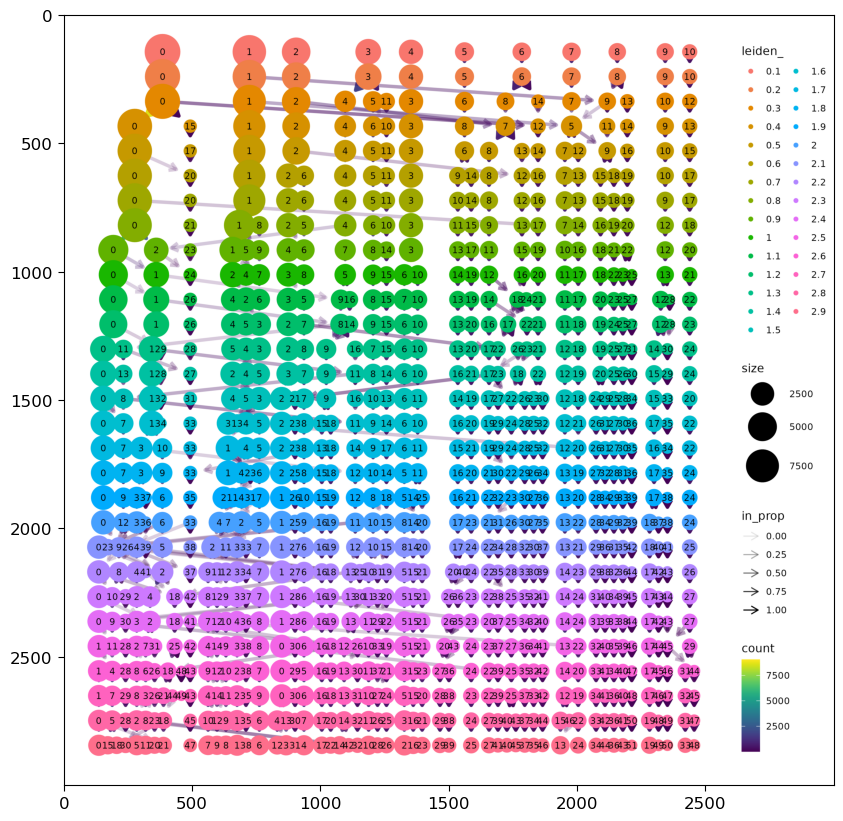

In [48]:
# | echo: false
# | warning: false


with TemporaryDirectory(dir=".") as f:
    input_dir = path.join(f, "leiden_clusters.csv")
    df = adata.obs.filter(regex="leiden_")
    df.to_csv(input_dir)
    system(f"Rscript ./utils/clustree.R -i {input_dir} -p leiden_ -o {f}")
    fig = plt.imread(path.join(f, "clustree.png"))

with rc_context({"figure.figsize": (10, 10)}):
    plt.imshow(fig)

In [49]:
# | echo: false
# | warning: false


# Source: https://evafast.github.io/blog/2019/06/28/example_content/

ig_obj = sc.Neighbors(adata).to_igraph()
results_df = pd.DataFrame(
    columns=["resolution", "number_of_clusters", "modularity", "davies_bouldin_score"]
)

for col in adata.obs.filter(regex="leiden_").columns:
    modularity_index = ig_obj.modularity(adata.obs[col].values.astype("int32"))
    davies_bouldin_avg = davies_bouldin_score(adata.obsm["X_pca"], adata.obs[col])
    df = pd.DataFrame(
        [
            [
                col,
                max(adata.obs[col].values.astype("int32")),
                davies_bouldin_avg,
                modularity_index,
            ]
        ],
        columns=[
            "resolution",
            "number_of_clusters",
            "davies_bouldin_score",
            "modularity",
        ],
    )

    results_df = pd.concat([results_df, df])
results_df = results_df.reset_index()


itables.show(results_df)

### Modularity 

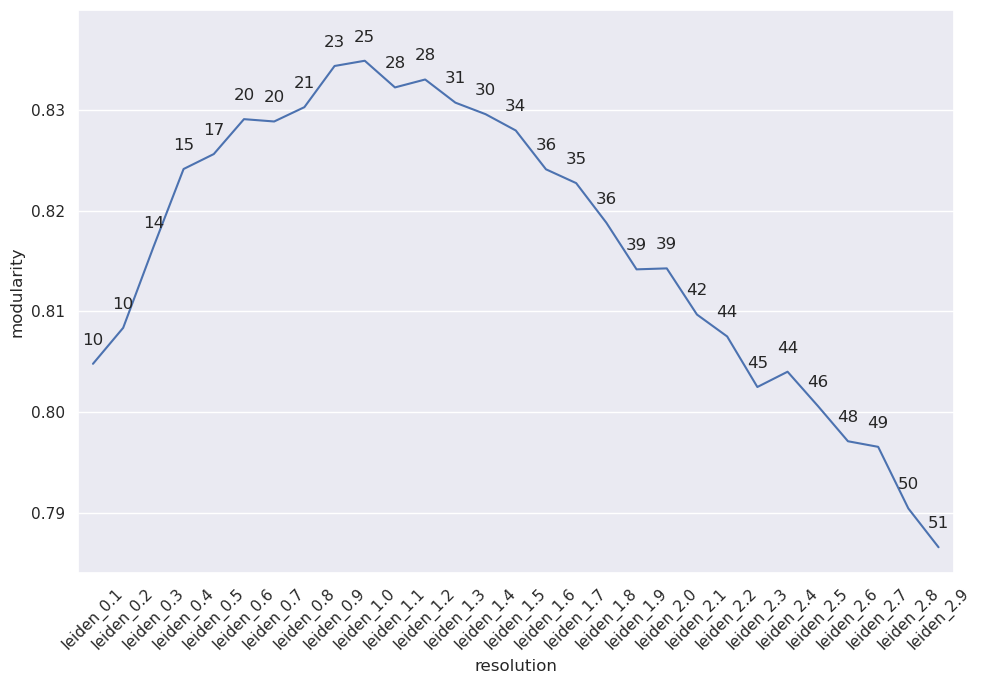

In [50]:
# | echo: false
# | warning: false


g = (
    so.Plot(results_df, "resolution", "modularity", text="number_of_clusters")
    .add(so.Line())
    .add(so.Text(), so.Shift(x=0.0, y=0.0025))
).theme({"figure.figsize": (10, 7)})

fig = g.plot()._figure
fig.axes[0].set_xticklabels(fig.axes[0].get_xticklabels(), rotation=45)
fig

### davies_bouldin_score

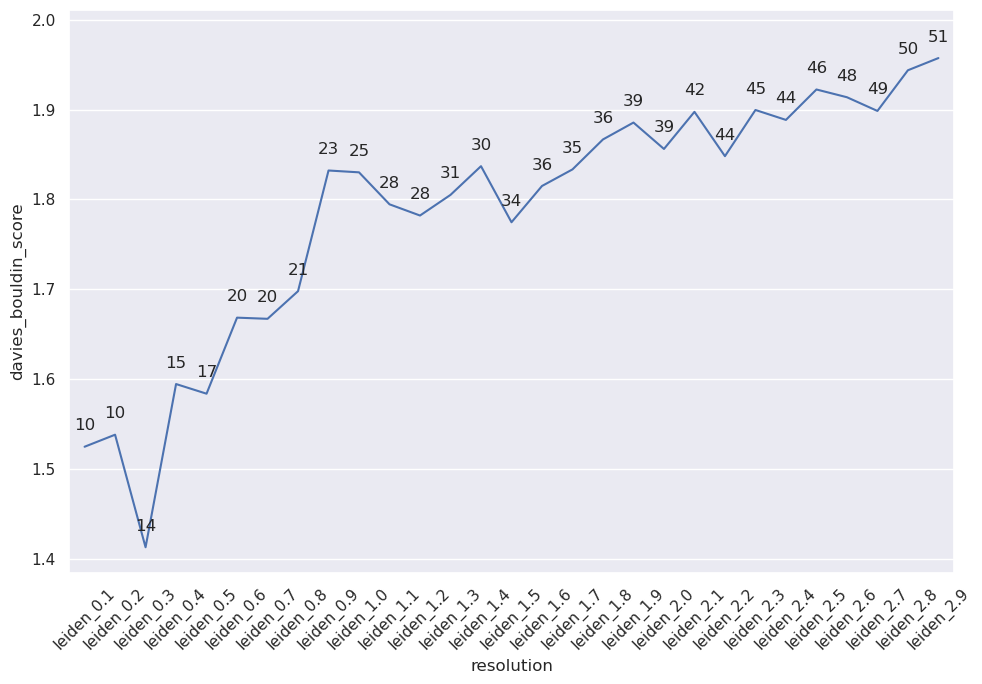

In [51]:
# | echo: false
# | warning: false


g = (
    so.Plot(results_df, "resolution", "davies_bouldin_score", text="number_of_clusters")
    .add(so.Line())
    .add(so.Text(), so.Shift(x=0.0, y=0.025))
).theme({"figure.figsize": (10, 7)})

fig = g.plot()._figure
fig.axes[0].set_xticklabels(fig.axes[0].get_xticklabels(), rotation=45)
fig

## Showing all clustering solution

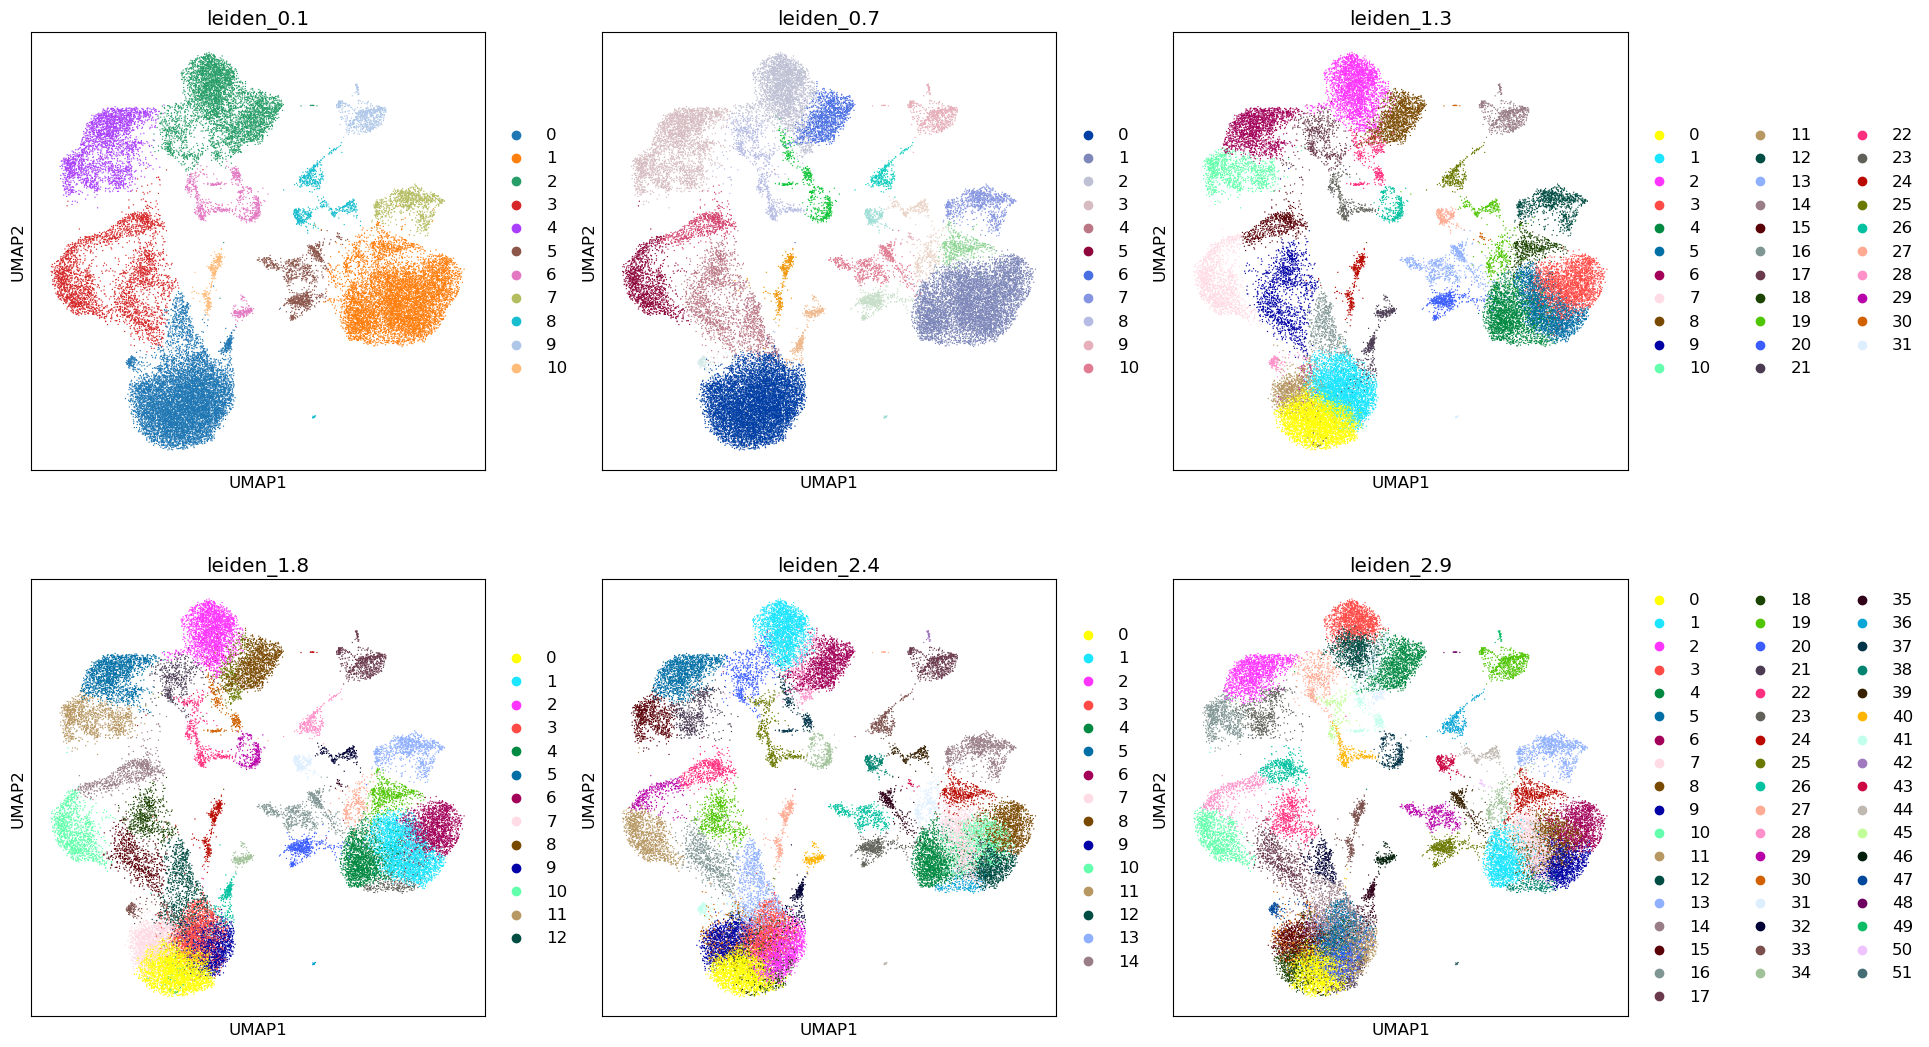

In [53]:
# | echo: false
# | warning: false
indcies = select_n_uniform(len(clustering_keys_added), 5)

if indcies[-1] != len(clustering_keys_added) - 1:
    indcies.append(len(clustering_keys_added) - 1)

plot_cols = [clustering_keys_added[i] for i in indcies]
with rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(adata, color=adata.obs[plot_cols].columns, ncols=3)

## Composition of Clusters

In [ ]:
## TODO

# Final Resolution

In [54]:
# | echo: false
# | warning: false

# Over-ride the final clustering col
# CLUSTERING_COL = ""

In [55]:
# | echo: false
# | warning: false

# TODO: Remove the unsed Clustering col

if len(CLUSTERING_COL) > 0 and CLUSTERING_COL not in adata.obs.columns:
    raise ValueError(f"{CLUSTERING_COL} column is not found in the object")

if len(CLUSTERING_COL) > 0 and CLUSTERING_COL in adata.obs.columns:
    adata.uns["CLUSTERING_COL"] = CLUSTERING_COL
    clustering_keys_added = list(
        set(clustering_keys_added).difference(set([CLUSTERING_COL]))
    )
    # Remove the unused clustering columns, Keep only the final clustering column.
    adata.obs.drop(columns=clustering_keys_added, inplace=True)
    adata.uns["FINAL_CLUSTERED"] = True
else:
    adata.uns["CLUSTERING_COL"] = ""
    adata.uns["FINAL_CLUSTERED"] = False

In [91]:
# | echo: false
# | output: false
# | warning: false

adata.write_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

# Session information

In [92]:
# | echo: false
# | warning: false
session_info.show()